# Kernel SVM Concepts and Examples

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we explore the use of kernel functions and illustrate how a kernel function can take data that is not linearly separable in the original space to a space where it is linearly separable.

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set_style('white')

In [ ]:
def plot_dataset(X, y):
    figure(figsize=(8,6))
    positives = X[y==1]
    negatives = X[y==-1]
    hold(True)
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    hold(False)
    show()
    
def plot_decision_function(df, X, y):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=[-1,0,1], 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=40, c='b', marker='o', label='positives', alpha=0.75)
    scatter(negatives[:,0], negatives[:,1], s=40, c='r', marker='o', label='negatives', alpha=0.75)
    legend()
    
    show()

## Generate data

Construct a 2D dataset that is not linearly separable. Here we create a Gaussian blob from one class and surround this with points from the other class. To generate the surrounding points, we just sample points on the unit circle and then perturb them with Gaussian noise.

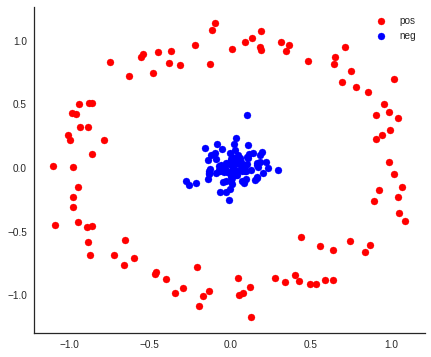

In [ ]:
# number of positive and negative points to generate
N = 100

# generate the outside points (positive)
r = 1  # circle radius
theta = np.linspace(0, 2*np.pi, N)
xs = r * np.sin(theta) + np.random.randn(N) * 0.1
ys = r * np.cos(theta) + np.random.randn(N) * 0.1
x_pos = np.c_[xs, ys]

# generate the inside points (negative)
xs = np.random.randn(N) * 0.1
ys = np.random.randn(N) * 0.1
x_neg = np.c_[xs, ys]

# plot
figure(figsize=(7,6))
scatter(x_pos[:, 0], x_pos[:, 1], color='red', label='pos')
scatter(x_neg[:, 0], x_neg[:, 1], color='blue', label='neg')
legend()
sns.despine()

## Feature mapping $\phi(x)$

We use a feature function  $\phi(x) : \mathbb{R}^2 \rightarrow \mathbb{R}^3$ to map this data into a space where we can separate it using a linear classifier:

$$\phi(x) = \begin{bmatrix} x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \end{bmatrix}$$.

In [ ]:
# Define our feature function phi
phi = lambda x: np.c_[x[:,0]**2, 2**0.5 * x[:,0] * x[:, 1], x[:,1]**2]

In [ ]:
# Map the data using phi
x_pos3 = phi(x_pos)
x_neg3 = phi(x_neg)

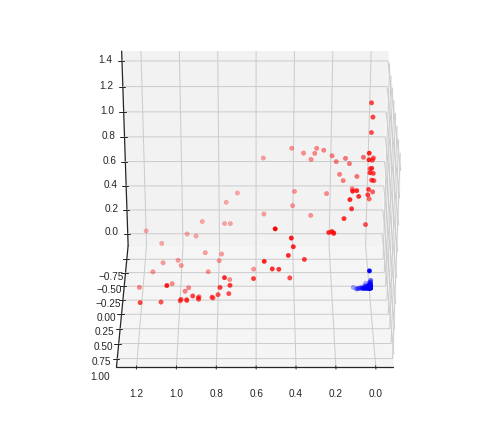

In [ ]:
# Plot to show it is linearly separable in the new space
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
x, y, z = x_pos3.T
ax.scatter(x, y, z, c='r')
x, y, z = x_neg3.T
ax.scatter(x, y, z, c='b')
ax.view_init(30, 90)
tight_layout()

## Some examples of using an SVM with different kernels

Here we use the scikit-learn kernel SVM implementation [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC).

In [ ]:
from sklearn.svm import SVC

Construct design matrix $X$ and target vector $y$

In [ ]:
X = np.concatenate([x_pos, x_neg])
y = np.concatenate([np.ones(N), -np.ones(N)])

### Linear kernel

$$K(x, z) = x^Tz$$

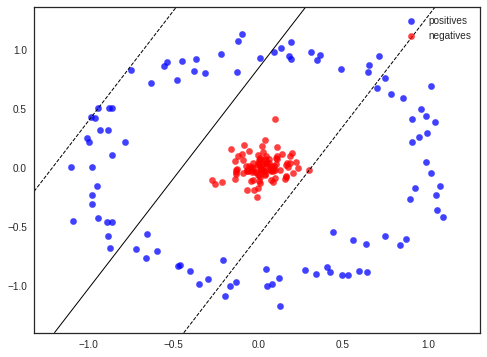

In [ ]:
# linear kernel
clf = SVC(kernel='linear')
clf.fit(X, y)
plot_decision_function(clf.decision_function, X, y)

### Degree 2 polynomial kernel

$$K(x, z) = (x^Tz + 1)^2$$

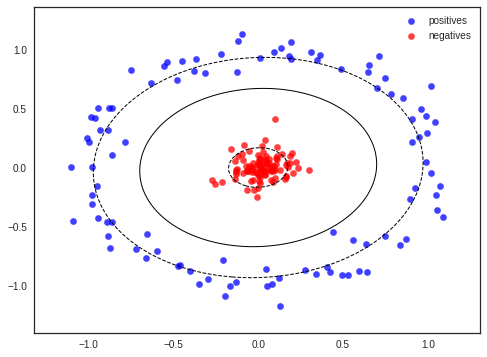

In [ ]:
# polynomial kernel, degree 2
clf = SVC(kernel='poly', degree=2)
clf.fit(X, y)
plot_decision_function(clf.decision_function, X, y)

### Degree 3 polynomial kernel

$$K(x, z) = (x^Tz + 1)^3$$

In [ ]:
# polynomial kernel, degree 3
clf = SVC(kernel='poly', degree=3)
clf.fit(X, y)
plot_decision_function(clf.decision_function, X, y)

### Radial basis function kernel

aka. Gaussian kernel.

$$K(x, z) = \exp\left(-\gamma\|x-z\|^2\right)$$

In [ ]:
# radial basis function (Gaussian kernel)
clf = SVC(kernel='rbf')
clf.fit(X, y)
plot_decision_function(clf.decision_function, X, y)

## Exercises

- Interrogate the fit RBF classifier `clf` to establish how many support vectors and how many total parameters the model has (Hint: look at the attributes of [SVC in the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC))
- Generate a new *test* dataset and use `clf.predict` to make predictions on the new points and `clf.score` to estimate accuracy.